In [6]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [7]:
#read dfs
shared_articles_df = pd.read_csv('shared_articles.csv')
users_interactions_df = pd.read_csv('users_interactions.csv')

In [6]:
print(users_interactions_df.head())

    timestamp eventType            contentId             personId  \
0  1465413032      VIEW -3499919498720038879 -8845298781299428018   
1  1465412560      VIEW  8890720798209849691 -1032019229384696495   
2  1465416190      VIEW   310515487419366995 -1130272294246983140   
3  1465413895    FOLLOW   310515487419366995   344280948527967603   
4  1465412290      VIEW -7820640624231356730  -445337111692715325   

             sessionId                                          userAgent  \
0  1264196770339959068                                                NaN   
1  3621737643587579081  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...   
2  2631864456530402479                                                NaN   
3 -3167637573980064150                                                NaN   
4  5611481178424124714                                                NaN   

  userRegion userCountry  
0        NaN         NaN  
1         NY          US  
2        NaN         NaN  
3        NaN  

In [7]:
print(shared_articles_df.head())

    timestamp        eventType            contentId       authorPersonId  \
0  1459192779  CONTENT REMOVED -6451309518266745024  4340306774493623681   
1  1459193988   CONTENT SHARED -4110354420726924665  4340306774493623681   
2  1459194146   CONTENT SHARED -7292285110016212249  4340306774493623681   
3  1459194474   CONTENT SHARED -6151852268067518688  3891637997717104548   
4  1459194497   CONTENT SHARED  2448026894306402386  4340306774493623681   

       authorSessionId authorUserAgent authorRegion authorCountry contentType  \
0  8940341205206233829             NaN          NaN           NaN        HTML   
1  8940341205206233829             NaN          NaN           NaN        HTML   
2  8940341205206233829             NaN          NaN           NaN        HTML   
3 -1457532940883382585             NaN          NaN           NaN        HTML   
4  8940341205206233829             NaN          NaN           NaN        HTML   

                                                 url  \


In [8]:
event_type_score = {
   'VIEW': 1.0,
   'LIKE': 4.0, 
   'COMMENT CREATED': 10.0,
   'FOLLOW': 25.0,
   'BOOKMARK': 100.0,
}

users_interactions_df['eventScore'] = users_interactions_df['eventType'].apply(lambda x: event_type_score[x])

In [9]:
users_interactions_count_df = users_interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('Total no. of users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('No. of users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

Total no. of users: 1895
No. of users with at least 5 interactions: 1140


In [10]:
print('# of interactions: %d' % len(users_interactions_df))
interactions_from_selected_users_df = users_interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 72312
# of interactions from users with at least 5 interactions: 69868


# Final Processed df

In [11]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventScore'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 39106


,personId,contentId,eventScore
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925
5,-9223121837663643404,-7331393944609614247,1.000000
6,-9223121837663643404,-6872546942144599345,1.000000
7,-9223121837663643404,-6728844082024523434,1.000000
8,-9223121837663643404,-6590819806697898649,1.000000
9,-9223121837663643404,-6558712014192834002,1.584963


Ps. A more robust evaluation approach could be to split train and test sets by a reference date, where the train set is composed by all interactions before that date, and the test set are interactions after that date. For the sake of simplicity, we chose the first random approach for this notebook, but you may want to try the second approach to better simulate how the recsys would perform in production predicting "future" users interactions.

# Train Test Split

In [12]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 31284
# interactions on Test set: 7822


# Evaluation

In [13]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [14]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [15]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(shared_articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator() 

# Popularity model

A common (and usually hard-to-beat) baseline approach is the Popularity model. This model is not actually personalized - it simply recommends to a user the most popular items that the user has not previously consumed. As the popularity accounts for the "wisdom of the crowds", it usually provides good recommendations, generally interesting for most people.
Ps. The main objective of a recommender system is to leverage the long-tail items to the users with very specific interests, which goes far beyond this simple technique.

In [16]:
#Computes the most popular items
item_popularity_df = interactions_full_df.groupby('contentId')['eventScore'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,eventScore
0,-4029704725707465084,400.121407
1,-6783772548752091658,296.212510
2,-6843047699859121724,266.634711
3,-133139342397538859,263.464403
4,-8208801367848627943,248.590077
5,8224860111193157980,246.792208
6,2581138407738454418,236.843428
7,-2358756719610361882,234.856085
8,3367026768872537336,222.405460
9,1469580151036142903,214.205882


In [23]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        print("user id is", user_id)
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventScore', ascending = False) \
                               .head(topn)
        
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventScore', 'contentId', 'title', 'url', 'lang']]
        
        print("printing recommendations df", recommendations_df.head())
        print("printing len of recommendations df",len(recommendations_df))
        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, shared_articles_df)

In [22]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
user id is -830175562779396891
2965
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2965
user id is -7267769888748948232
2854
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2854
user id is -3535274684588209118
2934
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
6  2581138407738454418  236.843428

user id is 1766257854965201953
2944
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2944
user id is 3915038251784681624
2923
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2923
user id is -5661737290289697460
2979
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
5  8224860111193157980  246.792208
6  2581138407738454418  236.843428
printing len of recommendations df 2979
user i

user id is -6810967503878969134
2962
verbose is False
printing recommendations df              contentId  eventScore
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
6  2581138407738454418  236.843428
printing len of recommendations df 2962
user id is 1763748489948355015
2978
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2978
user id is 520352373907677790
2952
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
6  2581138407738454418  236.843428
printing len of recommendations df 2952
user id

user id is -2979881261169775358
2635
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
8  3367026768872537336  222.405460
printing len of recommendations df 2635
user id is -3620817660824718175
2964
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2964
user id is 6574579966911353978
2978
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2978
user 

user id is 7890134385692540512
2909
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
6  2581138407738454418  236.843428
7 -2358756719610361882  234.856085
printing len of recommendations df 2909
user id is 8676130229735483748
2883
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2883
user id is 1895326251577378793
2787
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
6  2581138407738454418  236.843428
7 -2358756719610361882  234.856085
printing len of recommendations df 2787
user id

user id is -1836083230511905974
2919
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2919
user id is 2760160224512620259
2908
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2908
user id is -1393866732742189886
2857
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
6  2581138407738454418  236.843428
7 -2358756719610361882  234.856085
9  1469580151036142903  214.205882
printing len of recommendations df 2857
user 

2973
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2973
user id is -8606737560479590536
2929
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2929
user id is -634318177541615985
2948
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
5  8224860111193157980  246.792208
6  2581138407738454418  236.843428
8  3367026768872537336  222.405460
printing len of recommendations df 2948
user id is -6878112296616605612
2927


user id is -2690891220216547125
2952
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2952
user id is -2922237472410262877
2973
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2973
user id is 8841741572929644986
2946
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2946
user 

user id is 4142810830429822977
2962
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2962
user id is -8093344434152153830
2969
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2969
user id is -6874532444478397764
2965
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2965
user 

user id is 8663735706448940860
2953
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
5  8224860111193157980  246.792208
6  2581138407738454418  236.843428
printing len of recommendations df 2953
user id is -8670749047273764903
2958
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2958
user id is 3617923130431400422
2978
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2978
user i

user id is -6395289021795478412
2980
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2980
user id is 4335864930735272674
2980
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2980
user id is -5374802517306837266
2979
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2979
user 

user id is -2525380383541287600
2951
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2951
user id is 2349820930531316047
2970
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2970
user id is -3954277405987282296
2917
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2917
user 

user id is -663224541983667655
2974
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2974
user id is -7041401352840181657
2950
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2950
user id is 9050204922960952289
2978
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2978
user i

user id is -4746388521877686441
2959
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2959
user id is -3362047598052899495
2970
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2970
user id is -5087878572343192653
2975
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2975
user

user id is -4359668517495657229
2979
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
5  8224860111193157980  246.792208
printing len of recommendations df 2979
user id is -8388706028506253757
2968
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
6  2581138407738454418  236.843428
printing len of recommendations df 2968
user id is -6593243739839278571
2979
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2979
user

user id is 7047489233409645826
2975
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2975
user id is 7308881151087125462
2925
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2925
user id is -6364723726238328437
2980
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2980
user i

user id is -2457136404620190048
2964
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2964
user id is 1202287501580555390
2944
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
6  2581138407738454418  236.843428
printing len of recommendations df 2944
user id is -4384580909851654688
2956
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
4 -8208801367848627943  248.590077
6  2581138407738454418  236.843428
printing len of recommendations df 2956
user 

2957
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2957
user id is -8994220765455693336
2962
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2962
user id is -3325685634318512394
2932
verbose is False
printing recommendations df              contentId  eventScore
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
5  8224860111193157980  246.792208
6  2581138407738454418  236.843428
7 -2358756719610361882  234.856085
printing len of recommendations df 2932
user id is 3396828831632510915
2952


user id is 1234962692819082604
2970
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2970
user id is -8051903121006324833
2963
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2963
user id is 6489937596283721990
2977
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2977
user i

user id is 3734911646343191965
2955
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
2 -6843047699859121724  266.634711
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
6  2581138407738454418  236.843428
printing len of recommendations df 2955
user id is 2653698047369148236
2972
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2972
user id is 8892482595912468268
2971
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2971
user id

user id is -1367575386492755119
2954
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2954
user id is -7531858294361854119
2953
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2953
user id is 3763760030606782798
2975
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
4 -8208801367848627943  248.590077
6  2581138407738454418  236.843428
printing len of recommendations df 2975
user 

2966
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2966
user id is -6105296070998675410
2959
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2959
user id is 8237333675050684529
2947
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
6  2581138407738454418  236.843428
printing len of recommendations df 2947
user id is 4110069906204072059
2974
v

2961
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2961
user id is -3295609019604191449
2970
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2970
user id is 6176664770623035795
2979
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2979
user id is -960951213834982069
2973
v

user id is -8246472165248286476
2978
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2978
user id is 5443789138803907929
2974
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2974
user id is 5206835909720479405
2966
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2966
user i

user id is 813951249416003615
2976
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2976
user id is -1160159014793528221
2979
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2979
user id is -2376088187709738156
2971
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
5  8224860111193157980  246.792208
6  2581138407738454418  236.843428
printing len of recommendations df 2971
user i

2980
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2980
user id is -560055148675865863
2980
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2980
user id is 7780048623954214635
2980
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2980
user id is 7712504245368411024
2974
ve

user id is -5349775063975483956
2974
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2974
user id is 1915826476552544131
2976
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2976
user id is 8236260669729422750
2979
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2979
user i

user id is -4070244201184983176
2979
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2979
user id is -4447090897576014728
2962
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
6  2581138407738454418  236.843428
printing len of recommendations df 2962
user id is 8418615305660062636
2966
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
5  8224860111193157980  246.792208
6  2581138407738454418  236.843428
printing len of recommendations df 2966
user 

user id is -3325508780389598615
2971
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2971
user id is 8642864254981528773
2979
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2979
user id is 5331529367419076871
2975
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2975
user i

4 -8208801367848627943  248.590077
printing len of recommendations df 2977
user id is 6013800624570706808
2980
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2980
user id is -5404285628365611524
2972
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2972
user id is -900146660487611772
2979
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  822

user id is -8430239657678001264
2970
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
6  2581138407738454418  236.843428
printing len of recommendations df 2970
user id is -8223836278784533306
2980
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2980
user id is -710135072571868067
2980
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2980
user 

2974
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2974
user id is -7064549223277762524
2980
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2980
user id is 8862260182894039021
2970
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2970
user id is 6354670420844196172
2980
v

2974
verbose is False
printing recommendations df              contentId  eventScore
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2974
user id is -1119397949556155765
2979
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2979
user id is 5019290970146412524
2976
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
2 -6843047699859121724  266.634711
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
6  2581138407738454418  236.843428
printing len of recommendations df 2976
user id is 1294815114730489475
2977
v

2980
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2980
user id is -502319718136389439
2979
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2979
user id is 148641288870400064
2978
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
5  8224860111193157980  246.792208
printing len of recommendations df 2978
user id is 3743262342828860520
2966
ver

user id is -4716637009380371036
2980
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2980
user id is 5598109800222509376
2979
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
1 -6783772548752091658  296.212510
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
printing len of recommendations df 2979
user id is -2987910693129502800
2978
verbose is False
printing recommendations df              contentId  eventScore
0 -4029704725707465084  400.121407
2 -6843047699859121724  266.634711
3  -133139342397538859  263.464403
4 -8208801367848627943  248.590077
5  8224860111193157980  246.792208
printing len of recommendations df 2978
user 


Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.23983635898747124, 'recall@10': 0.3671695218614165}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,27,47,192,0.140625,0.244792,3609194402293569455
17,12,27,134,0.089552,0.201493,-2626634673110551643
16,14,26,130,0.107692,0.200000,-1032019229384696495
10,4,11,117,0.034188,0.094017,-1443636648652872475
82,26,34,88,0.295455,0.386364,-2979881261169775358
161,13,20,80,0.162500,0.250000,-3596626804281480007
65,21,31,73,0.287671,0.424658,1116121227607581999
81,17,21,69,0.246377,0.304348,692689608292948411
106,14,20,69,0.202899,0.289855,-9016528795238256703
52,20,28,68,0.294118,0.411765,3636910968448833585


# Content-Based Filtering model

Content-based filtering approaches leverage description or attributes from items the user has interacted to recommend similar items. It depends only on the user previous choices, making this method robust to avoid the cold-start problem. For textual items, like articles, news and books, it is simple to use the raw text to build item profiles and user profiles.
Here we are using a very popular technique in information retrieval (search engines) named TF-IDF. This technique converts unstructured text into a vector structure, where each word is represented by a position in the vector, and the value measures how relevant a given word is for an article. As all items will be represented in the same Vector Space Model, it is to compute similarity between articles.
See this presentation (from slide 30) for more information on TF-IDF and Cosine similarity.

In [44]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = shared_articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(shared_articles_df['title'] + "" + shared_articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<3122x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 652972 stored elements in Compressed Sparse Row format>

To model the user profile, we take all the item profiles the user has interacted and average them. The average is weighted by the interaction strength, in other words, the articles the user has interacted the most (eg. liked or commented) will have a higher strength in the final user profile.

In [49]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventScore']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['contentId'] \
                                                   .isin(shared_articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [50]:
user_profiles = build_users_profiles()
len(user_profiles)

1140

Let's take a look in the profile. It is a unit vector of 5000 length. The value in each position represents how relevant is a token (unigram or bigram) for me.
Looking my profile, it appears that the top relevant tokens really represent my professional interests in machine learning, deep learning, artificial intelligence and google cloud platform! So we might expect good recommendations here!

In [51]:
myprofile = user_profiles[-1479311724257856983]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[-1479311724257856983].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,learning,0.279296
1,machine learning,0.232067
2,machine,0.223932
3,data,0.186191
4,google,0.180984
5,ai,0.171783
6,algorithms,0.110636
7,like,0.101066
8,models,0.093042
9,language,0.088493


In [53]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(shared_articles_df)

With personalized recommendations of content-based filtering model, we have a Recall@5 to about 0.162, which means that about 16% of interacted items in test set were ranked by this model among the top-5 items (from lists with 100 random items). And Recall@10 was 0.261 (52%). The lower performance of the Content-Based model compared to the Popularity model may indicate that users are not that fixed in content very similar to their previous reads.

In [54]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
1139 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.16312963436461264, 'recall@10': 0.2570953720276144}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,16,25,192,0.083333,0.130208,3609194402293569455
17,14,33,134,0.104478,0.246269,-2626634673110551643
16,18,31,130,0.138462,0.238462,-1032019229384696495
10,30,49,117,0.256410,0.418803,-1443636648652872475
82,7,17,88,0.079545,0.193182,-2979881261169775358
161,14,24,80,0.175000,0.300000,-3596626804281480007
65,6,13,73,0.082192,0.178082,1116121227607581999
81,9,20,69,0.130435,0.289855,692689608292948411
106,4,10,69,0.057971,0.144928,-9016528795238256703
52,4,9,68,0.058824,0.132353,3636910968448833585


# Collaborative Filtering model

Collaborative Filtering (CF) has two main implementation strategies:

Memory-based: This approach uses the memory of previous users interactions to compute users similarities based on items they've interacted (user-based approach) or compute items similarities based on the users that have interacted with them (item-based approach).
A typical example of this approach is User Neighbourhood-based CF, in which the top-N similar users (usually computed using Pearson correlation) for a user are selected and used to recommend items those similar users liked, but the current user have not interacted yet. This approach is very simple to implement, but usually do not scale well for many users. A nice Python implementation of this approach in available in Crab.
Model-based: This approach, models are developed using different machine learning algorithms to recommend items to users. There are many model-based CF algorithms, like neural networks, bayesian networks, clustering models, and latent factor models such as Singular Value Decomposition (SVD) and, probabilistic latent semantic analysis.

## Matrix Factorization

Latent factor models compress user-item matrix into a low-dimensional representation in terms of latent factors. One advantage of using this approach is that instead of having a high dimensional matrix containing abundant number of missing values we will be dealing with a much smaller matrix in lower-dimensional space.
A reduced presentation could be utilized for either user-based or item-based neighborhood algorithms that are presented in the previous section. There are several advantages with this paradigm. It handles the sparsity of the original matrix better than memory based ones. Also comparing similarity on the resulting matrix is much more scalable especially in dealing with large sparse datasets.

Here we a use popular latent factor model named Singular Value Decomposition (SVD). There are other matrix factorization frameworks more specific to CF you might try, like surprise, mrec or python-recsys. We chose a SciPy implemenation of SVD because it is available on Kaggle kernels. P.s. See an example of SVD on a movies dataset in this blog post.

An important decision is the number of factors to factor the user-item matrix. The higher the number of factors, the more precise is the factorization in the original matrix reconstructions. Therefore, if the model is allowed to memorize too much details of the original matrix, it may not generalize well for data it was not trained on. Reducing the number of factors increases the model generalization.

In [56]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventScore').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.584963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix[:10]

/home/vijay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 2.5849625, 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [58]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [59]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<1140x2926 sparse matrix of type '<class 'numpy.float64'>'
	with 31284 stored elements in Compressed Sparse Row format>

In [60]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [61]:
U.shape

(1140, 15)

In [62]:
Vt.shape

(15, 2926)

In [63]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.

In [64]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 3.30833060e-02, -3.14910043e-03, -1.47625674e-02, ...,
         3.92426588e-02,  1.33587544e-02,  1.08684470e-03],
       [ 2.08624201e-03, -6.71273609e-05, -1.08386791e-02, ...,
        -3.44654653e-04,  3.74583443e-03, -4.54410570e-04],
       [-3.69324817e-02,  1.64200128e-02,  1.33758977e-02, ...,
        -7.44883277e-03, -8.03930792e-03,  1.17430650e-02],
       ...,
       [-4.55644226e-02,  6.66240465e-03, -3.32873233e-02, ...,
        -1.80450220e-02,  1.29688068e-02,  5.41692187e-03],
       [ 1.25536983e-03,  4.13180261e-03,  2.44261580e-02, ...,
         1.15189410e-02,  2.65788646e-03,  2.26129918e-03],
       [-4.36347059e-02,  1.10477449e-02,  3.79106373e-01, ...,
        -5.08940739e-02,  4.96860238e-02,  2.90325376e-02]])

In [65]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [66]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.168675,0.166677,0.164162,0.169602,0.166372,0.165945,0.167594,0.168796,0.164931,0.166892,...,0.167771,0.165076,0.166659,0.166945,0.163895,0.165577,0.166099,0.163606,0.166623,0.163730
-9216926795620865886,0.166340,0.166538,0.167601,0.166550,0.166671,0.166530,0.166574,0.166561,0.166312,0.166501,...,0.166617,0.167951,0.166653,0.166653,0.169649,0.166985,0.166841,0.166972,0.166809,0.167255
-9194572880052200111,0.165591,0.165844,0.167405,0.165743,0.169016,0.166232,0.167787,0.166392,0.161184,0.169833,...,0.166875,0.169081,0.167513,0.168338,0.186497,0.173048,0.168124,0.164397,0.168117,0.190978
-9192549002213406534,0.167339,0.167041,0.165995,0.166352,0.166812,0.167627,0.166924,0.169401,0.169858,0.165377,...,0.167566,0.180016,0.166897,0.166422,0.175936,0.166736,0.167970,0.166790,0.167155,0.170969
-9190737901804729417,0.167170,0.166461,0.167094,0.167014,0.166556,0.166536,0.166864,0.166710,0.165459,0.167215,...,0.166829,0.165188,0.166432,0.166585,0.165766,0.166567,0.166620,0.166344,0.166746,0.166476
-9189659052158407108,0.167613,0.166666,0.167473,0.166282,0.167479,0.166609,0.166752,0.167428,0.170490,0.167238,...,0.166984,0.170500,0.166000,0.166643,0.171754,0.169528,0.166583,0.168305,0.167683,0.176399
-9176143510534135851,0.168002,0.166754,0.167746,0.167049,0.166218,0.166360,0.167007,0.167683,0.169578,0.168961,...,0.166704,0.172673,0.166593,0.166793,0.164910,0.165654,0.166571,0.168901,0.167428,0.165775
-9172673334835262304,0.166604,0.166646,0.166454,0.166543,0.166559,0.166683,0.166561,0.166575,0.166160,0.166533,...,0.166828,0.167780,0.166735,0.166430,0.167794,0.166410,0.166907,0.166411,0.166602,0.165460
-9171475473795142532,0.167910,0.166376,0.166768,0.166397,0.166741,0.166794,0.167120,0.166526,0.164991,0.168324,...,0.166599,0.165090,0.166520,0.166641,0.166318,0.167018,0.166445,0.166294,0.166854,0.168143


In [67]:
len(cf_preds_df.columns)

1140

In [69]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, shared_articles_df)

Evaluating the Collaborative Filtering model (SVD matrix factorization), we observe that we got Recall@5 (33%) and Recall@10 (46%) values, much higher than Popularity model and Content-Based model.

In [70]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1139 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.2864996164663769, 'recall@10': 0.4204806954743032}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,16,34,192,0.083333,0.177083,3609194402293569455
17,27,36,134,0.201493,0.268657,-2626634673110551643
16,18,43,130,0.138462,0.330769,-1032019229384696495
10,34,46,117,0.290598,0.393162,-1443636648652872475
82,28,48,88,0.318182,0.545455,-2979881261169775358
161,21,32,80,0.262500,0.400000,-3596626804281480007
65,17,26,73,0.232877,0.356164,1116121227607581999
81,12,20,69,0.173913,0.289855,692689608292948411
106,14,23,69,0.202899,0.333333,-9016528795238256703
52,19,28,68,0.279412,0.411765,3636910968448833585


# Hybrid Recommender

In [72]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) \
                                     + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, shared_articles_df,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=100.0)


We have a new champion!
Our simple hybrid approach surpasses Content-Based filtering with its combination with Collaborative Filtering. Now we have a Recall@5 of 34.2% and Recall@10 of 47.9%

In [73]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
1139 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.2978777806187676, 'recall@10': 0.43006903605216057}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,18,37,192,0.093750,0.192708,3609194402293569455
17,26,39,134,0.194030,0.291045,-2626634673110551643
16,24,37,130,0.184615,0.284615,-1032019229384696495
10,37,49,117,0.316239,0.418803,-1443636648652872475
82,25,48,88,0.284091,0.545455,-2979881261169775358
161,21,32,80,0.262500,0.400000,-3596626804281480007
65,17,26,73,0.232877,0.356164,1116121227607581999
81,12,19,69,0.173913,0.275362,692689608292948411
106,13,23,69,0.188406,0.333333,-9016528795238256703
52,20,29,68,0.294118,0.426471,3636910968448833585


# Comparing the methods

In [76]:
global_metrics_df = pd.DataFrame([cb_global_metrics, pop_global_metrics, cf_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df


,recall@5,recall@10
modelName,,
Content-Based,0.163130,0.257095
Popularity,0.239836,0.367170
Collaborative Filtering,0.286500,0.420481
Hybrid,0.297878,0.430069


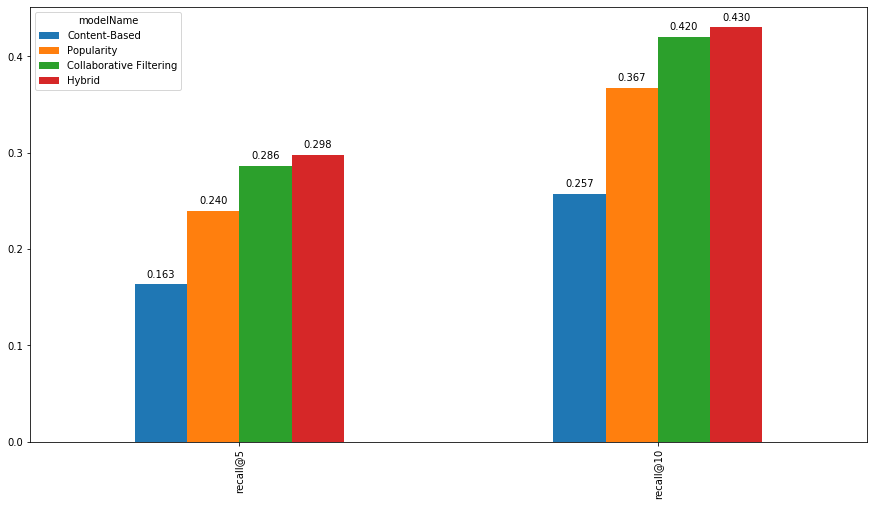

In [77]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Testing

Let's test the best model (Hybrid) for my user

In [81]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(shared_articles_df, how = 'left', 
                                                      left_on = 'contentId', 
                                                      right_on = 'contentId') \
                          .sort_values('eventScore', ascending = False)[['eventScore', 
                                                                          'contentId',
                                                                          'title', 'url', 'lang']]

Here we see some articles I interacted in Deskdrop from train set. It can be easily observed that among my main interests are machine learning, deep learning, artificial intelligence, and google cloud platform.

In [82]:
inspect_interactions(-1479311724257856983, test_set=False).head(20)

,eventScore,contentId,title,url,lang
115,7.199672,7342707578347442862,"At eBay, Machine Learning is Driving Innovativ...",https://www.ebayinc.com/stories/news/at-ebay-m...,en
113,6.882643,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
42,6.870365,-4944551138301474550,Algorithms and architecture for job recommenda...,https://www.oreilly.com/ideas/algorithms-and-a...,en
38,6.845490,621816023396605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
116,6.845490,-7959318068735027467,Auto-scaling scikit-learn with Spark,https://databricks.com/blog/2016/02/08/auto-sc...,en
8,6.832890,-4460374799273064357,"Deep Learning for Chatbots, Part 1 - Introduction",http://www.wildml.com/2016/04/deep-learning-fo...,en
97,6.754888,2623290164732957912,Creative Applications of Deep Learning with Te...,https://www.kadenze.com/courses/creative-appli...,en
78,6.741467,-3920124114454832425,Worldwide Ops in Minutes with DataStax & Cloud,http://www.datastax.com/2016/01/datastax-enter...,en
72,6.727920,5237574390644778994,Meet Parsey's Cousins: Syntax for 40 languages...,https://research.googleblog.com/2016/08/meet-p...,en
13,6.686501,3064370296170038610,"Google, Amazon and the upcoming battle over AI...",https://www.linkedin.com/pulse/google-amazon-u...,en


The recommendations really matches my interests, as I would read all of them!

## get recommendations for given personId

In [83]:
hybrid_recommender_model.recommend_items(-1479311724257856983, topn=20, verbose=True)

,recStrengthHybrid,contentId,title,url,lang
0,27.006072,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...,en
1,26.634403,-1901742495252324928,Designing smart notifications,https://medium.com/@intercom/designing-smart-n...,en
2,26.357719,5092635400707338872,Power to the People: How One Unknown Group of ...,https://medium.com/@atduskgreg/power-to-the-pe...,en
3,26.005638,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
4,25.750844,-6727357771678896471,This Super Accurate Portrait Selection Tech Us...,http://petapixel.com/2016/06/29/super-accurate...,en
5,25.715583,-5253644367331262405,"Hello, TensorFlow!",https://www.oreilly.com/learning/hello-tensorflow,en
6,25.649904,621816023396605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
7,25.513489,7395435905985567130,The AI business landscape,https://www.oreilly.com/ideas/the-ai-business-...,en
8,25.430867,-8085935119790093311,Graph Capabilities with the Elastic Stack,https://www.elastic.co/webinars/sneak-peek-of-...,en
9,25.119596,-4944551138301474550,Algorithms and architecture for job recommenda...,https://www.oreilly.com/ideas/algorithms-and-a...,en
